In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

from chiseling.dgps.benchtm import BenchTM
from chiseling.source.protocol.utils import aipw_intercept_pseudo_outcome
from chiseling.source.learners.utility_tree import UDecisionTree
from chiseling.source.learners.utility_forest import URandomForest
from chiseling.source.learners.r_transform import EfficientPOForest

### Sanity checks

Single‑point sanity check: [1 0]


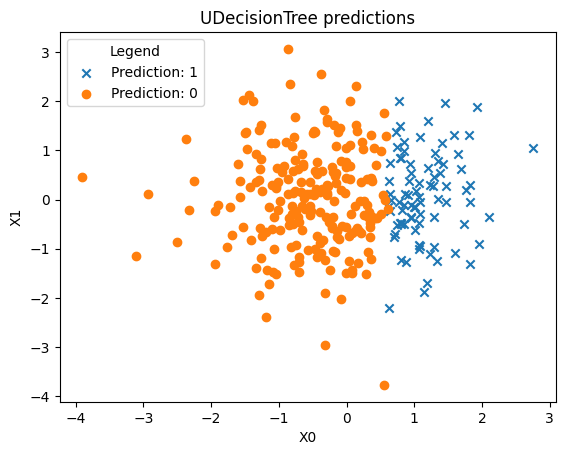

In [3]:
# --- Generate data -----------------------------------------------------------
rng = np.random.default_rng(0)
X = rng.normal(size=(300, 2))
Y = 0.2 * (X[:, 0] > 0).astype(float) + rng.normal(size=300)

# --- Fit the tree ------------------------------------------------------------
tree = UDecisionTree(eps_min=0, d_max=1, random_state=0, n_test=50).fit(X, Y)

# --- Predictions -------------------------------------------------------------
print("Single‑point sanity check:", tree.predict([[1.0, 0.0], [-1.0, 0.0]]))

preds = tree.predict(X)

# ---- Scatter plot with legend ----------------------------------------------
plt.figure()
idx1 = preds == 1
idx0 = ~idx1
plt.scatter(X[idx1,0], X[idx1,1], marker="x", label="Prediction: 1")
plt.scatter(X[idx0,0], X[idx0,1], marker="o", label="Prediction: 0")
plt.xlabel("X0")
plt.ylabel("X1")
plt.title("UDecisionTree predictions")
plt.legend(title="Legend")
plt.show()

Single‑point sanity check: [1 0]


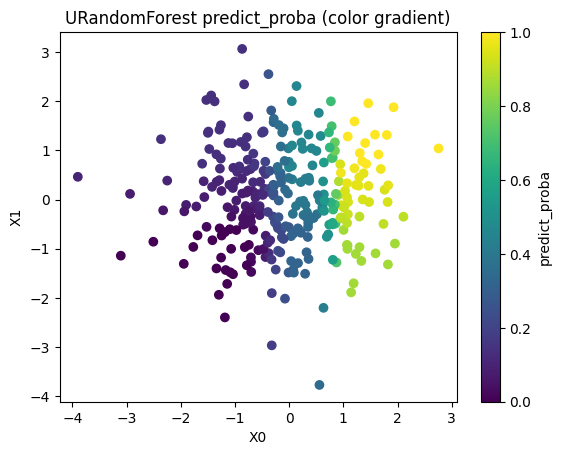

In [4]:
# --- Generate data -----------------------------------------------------------
rng = np.random.default_rng(0)
X = rng.normal(size=(300, 2))
Y = 0.2 * (X[:, 0] > 0).astype(float) + rng.normal(size=300)

# --- Fit the forest ------------------------------------------------------------
forest = URandomForest(n_trees=50, eps_min=0, d_max=1, random_state=0, n_test=50).fit(X, Y)

# --- Predictions -------------------------------------------------------------
print("Single‑point sanity check:", forest.predict([[1.0, 0.0], [-1.0, 0.0]]))

proba = forest.predict_proba(X)

plt.figure()
scatter = plt.scatter(X[:, 0], X[:, 1], c=proba, cmap='viridis')
plt.colorbar(scatter, label='predict_proba')
plt.xlabel("X0")
plt.ylabel("X1")
plt.title("URandomForest predict_proba (color gradient)")
plt.show()

### BenchTM

In [5]:
np.random.seed(42)

In [6]:
def eval_region(tree, sampler, n_reps=10000):
    samp_inds = np.random.choice(sampler.X.shape[0], n_reps, replace=True)
    X_eval = sampler.X[samp_inds]
    trt_effect_eval = sampler.benchtm_df.trt_effect.values[samp_inds]
    preds_eval = tree.predict(X_eval)
    util = (trt_effect_eval * preds_eval).mean()
    return util

def sim_once(sampler, n, k, k_remain):
    # Sample and format
    TX, Y = sampler.sample(n)
    T, X = TX[:,0], TX[:,1:]
    T_train, X_train, Y_train = T[:k], X[:k], Y[:k]
    T_test, X_test, Y_test = T[k:], X[k:], Y[k:]
    # T-test
    pY = aipw_intercept_pseudo_outcome(T, X, Y, random_seed=0)
    # Full sample analysis
    ttest_full_res = scipy.stats.ttest_1samp(pY, 0, alternative="greater")
    ttest_full_rej = ttest_full_res.pvalue <= 0.05
    # Test sample analysis
    ttest_test_res = scipy.stats.ttest_1samp(pY[k:], 0, alternative="greater")
    ttest_test_rej = ttest_test_res.pvalue <= 0.05
    # Tree
    pY_train = aipw_intercept_pseudo_outcome(T_train, X_train, Y_train, random_seed=0)
    tree = UDecisionTree(eps_min=0, d_max=1, random_state=0, n_test=k_remain)
    tree = tree.fit(X_train, pY_train)
    preds = tree.predict(X_test)
    tree_res = scipy.stats.ttest_1samp(pY[k:][preds==1], 0, alternative="greater")
    tree_util = eval_region(tree, sampler)
    tree_rej = tree_res.pvalue <= 0.05
    # Return
    return ttest_full_rej, ttest_test_rej, tree_rej, tree_util

##### Heterogeneous

In [7]:
n = 1000
random_seed = 42
alpha = 0.05
benchtm_path = "../../../benchtm/"

n_sims = 200

In [8]:
k = 500
k_remain = n - k

In [9]:
# Construct sampler
sampler = BenchTM(scenario=5, benchtm_path=benchtm_path, random_seed=random_seed)

In [10]:
# Simulate
all_ttest_full_rej = []
all_ttest_test_rej = []
all_tree_rej = []
all_tree_util = []
for _ in range(n_sims):
    if _ % 10 == 0:
        print("Progress = {}".format(_))
    ttest_full_rej, ttest_test_rej, tree_rej, tree_util = sim_once(sampler, n, k, k_remain)
    all_ttest_full_rej.append(ttest_full_rej)
    all_ttest_test_rej.append(ttest_test_rej)
    all_tree_rej.append(tree_rej)
    all_tree_util.append(tree_util)
all_ttest_full_rej = np.array(all_ttest_full_rej)
all_ttest_test_rej = np.array(all_ttest_test_rej)
all_tree_rej = np.array(all_tree_rej)
all_tree_util = np.array(all_tree_util)

Progress = 0
Progress = 10
Progress = 20
Progress = 30
Progress = 40
Progress = 50
Progress = 60
Progress = 70
Progress = 80
Progress = 90
Progress = 100
Progress = 110
Progress = 120
Progress = 130
Progress = 140
Progress = 150
Progress = 160
Progress = 170
Progress = 180
Progress = 190


In [11]:
full_power, test_power, tree_power = (all_ttest_full_rej.mean(),
                                      all_ttest_test_rej.mean(),
                                      all_tree_rej.mean())
full_util, test_util, tree_util = (all_ttest_full_rej.mean() * sampler.benchtm_df.trt_effect.mean(),
                                   all_ttest_test_rej.mean() * sampler.benchtm_df.trt_effect.mean(),
                                   (all_tree_util * all_tree_rej).mean())
print("Full power = {}, test power = {}, tree power = {}".format(full_power, test_power, tree_power))
print("Full util = {}, test util = {}, tree util = {}".format(full_util, test_util, tree_util))

Full power = 0.9, test power = 0.58, tree power = 0.705
Full util = 0.2016485804532518, test util = 0.1299513074032067, tree util = 0.15417411557093533


##### Non-heterogeneous

In [12]:
n = 1000
random_seed = 42
alpha = 0.05
benchtm_path = "../../../benchtm/"

n_sims = 200

In [13]:
k = 500
k_remain = n - k

In [14]:
# Construct sampler
sampler = BenchTM(scenario=1, benchtm_path=benchtm_path, random_seed=random_seed)

In [15]:
# Simulate
all_ttest_full_rej = []
all_ttest_test_rej = []
all_tree_rej = []
all_tree_util = []
for _ in range(n_sims):
    if _ % 10 == 0:
        print("Progress = {}".format(_))
    ttest_full_rej, ttest_test_rej, tree_rej, tree_util = sim_once(sampler, n, k, k_remain)
    all_ttest_full_rej.append(ttest_full_rej)
    all_ttest_test_rej.append(ttest_test_rej)
    all_tree_rej.append(tree_rej)
    all_tree_util.append(tree_util)
all_ttest_full_rej = np.array(all_ttest_full_rej)
all_ttest_test_rej = np.array(all_ttest_test_rej)
all_tree_rej = np.array(all_tree_rej)
all_tree_util = np.array(all_tree_util)

Progress = 0
Progress = 10
Progress = 20
Progress = 30
Progress = 40
Progress = 50
Progress = 60
Progress = 70
Progress = 80
Progress = 90
Progress = 100
Progress = 110
Progress = 120
Progress = 130
Progress = 140
Progress = 150
Progress = 160
Progress = 170
Progress = 180
Progress = 190


In [16]:
full_power, test_power, tree_power = (all_ttest_full_rej.mean(),
                                      all_ttest_test_rej.mean(),
                                      all_tree_rej.mean())
full_util, test_util, tree_util = (all_ttest_full_rej.mean() * sampler.benchtm_df.trt_effect.mean(),
                                   all_ttest_test_rej.mean() * sampler.benchtm_df.trt_effect.mean(),
                                   (all_tree_util * all_tree_rej).mean())
print("Full power = {}, test power = {}, tree power = {}".format(full_power, test_power, tree_power))
print("Full util = {}, test util = {}, tree util = {}".format(full_util, test_util, tree_util))

Full power = 0.885, test power = 0.645, tree power = 0.51
Full util = 0.18797399999999972, test util = 0.13699799999999981, tree util = 0.07956397800000001
